___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-1 (ANN)<br><br>Churn Prediction for Bank Customer<br><h1>

## Import  libraries & data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, ConfusionMatrixDisplay,\
RocCurveDisplay, roc_auc_score,roc_curve
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import pickle
import warnings
import os
import optuna

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
sns.set_style('whitegrid')

In [8]:
from google.colab import files
uploaded = files.upload()


Saving Churn_Modelling.csv to Churn_Modelling (1).csv


In [9]:
df = pd.read_csv('Churn_Modelling.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


## Exploratory Data Analysis and Visualization

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [11]:
df.shape

(10000, 14)

In [12]:
df.isnull().sum().any()

False

In [13]:
df.duplicated().sum()

0

In [14]:
df.describe().T



,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [15]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

0    7963
1    2037
Name: Exited, dtype: int64


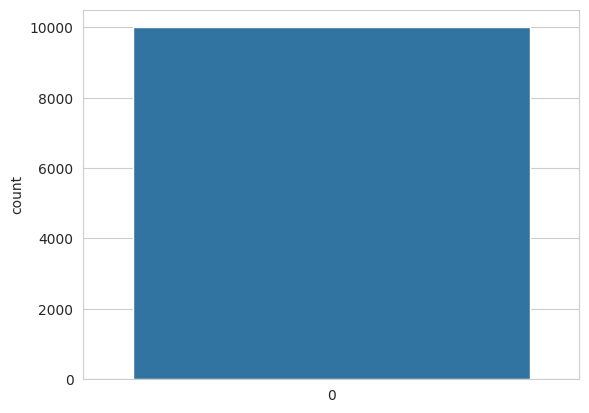

In [16]:
print(df.Exited.value_counts())
sns.countplot(df["Exited"]);

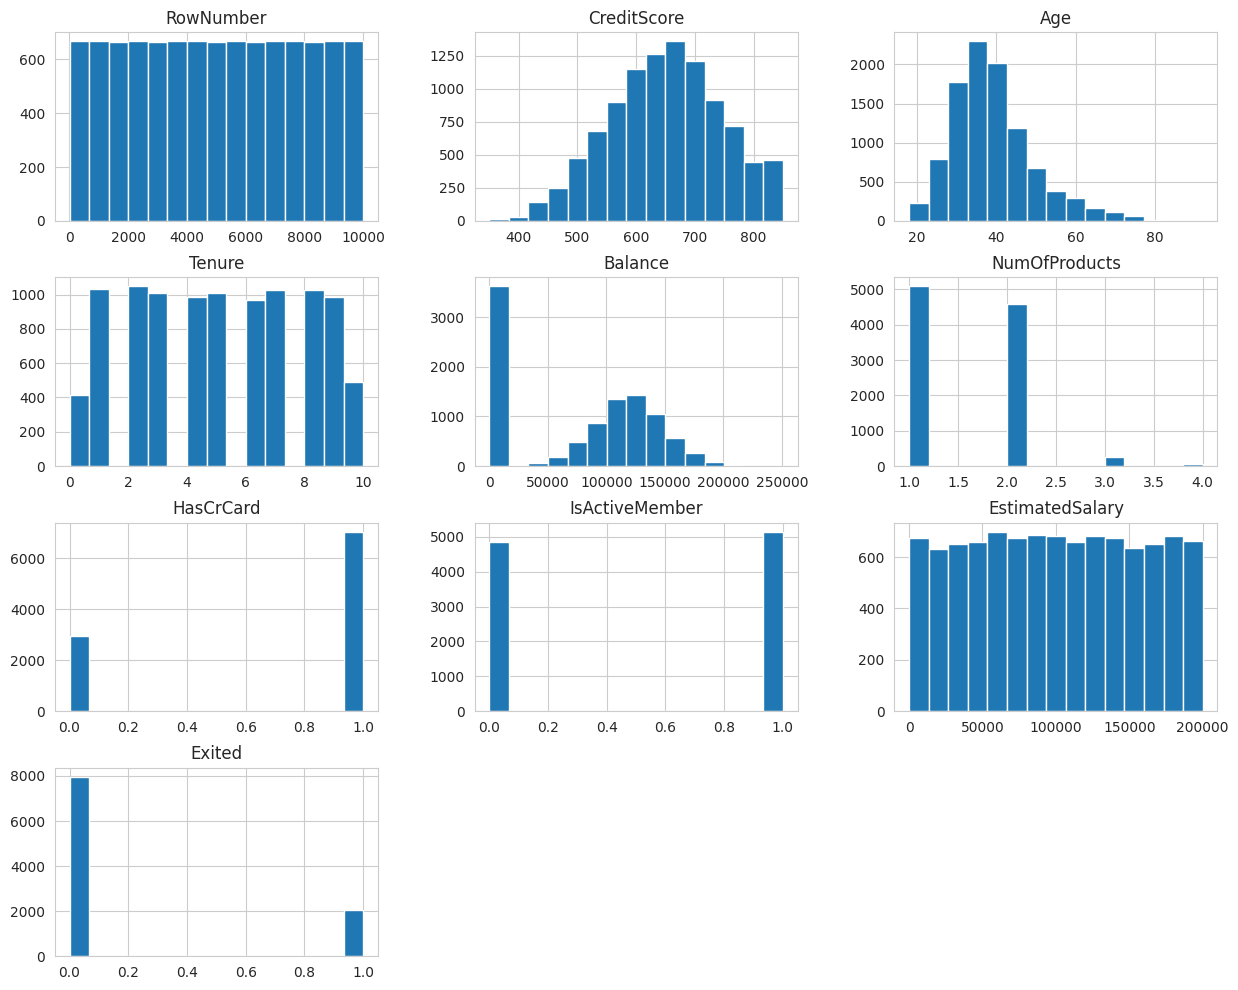

In [17]:
df.hist(figsize=(15, 12), bins=15);


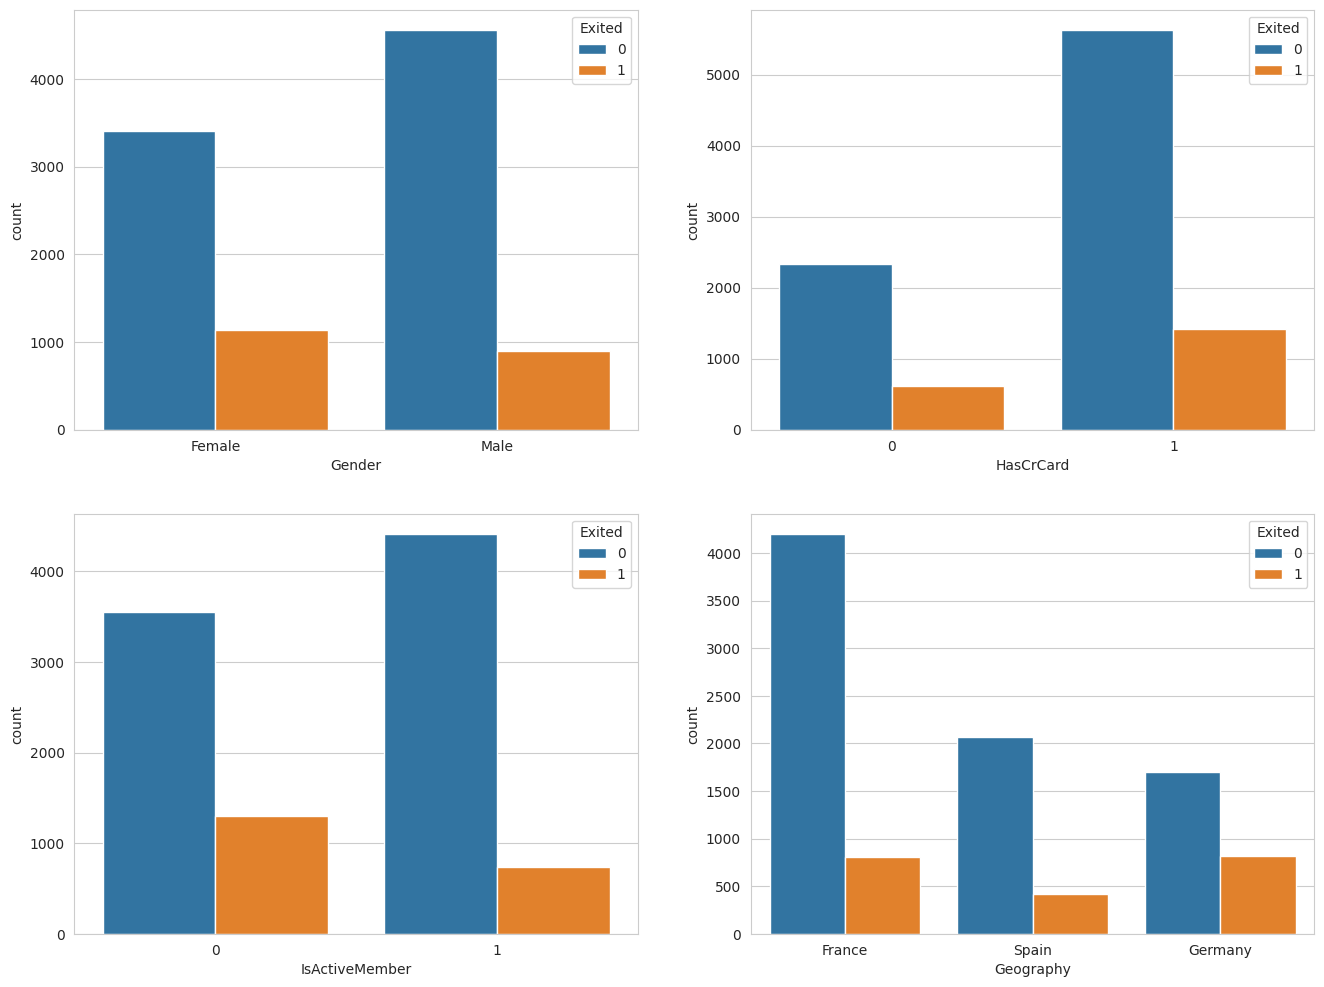

In [18]:
cat_list = ["Gender", "HasCrCard", "IsActiveMember", "Geography"]
index = 0
plt.figure(figsize=(16, 12))
for i in cat_list:
    index += 1
    plt.subplot(2, 2, index)
    sns.countplot(data=df, x=i, hue="Exited")

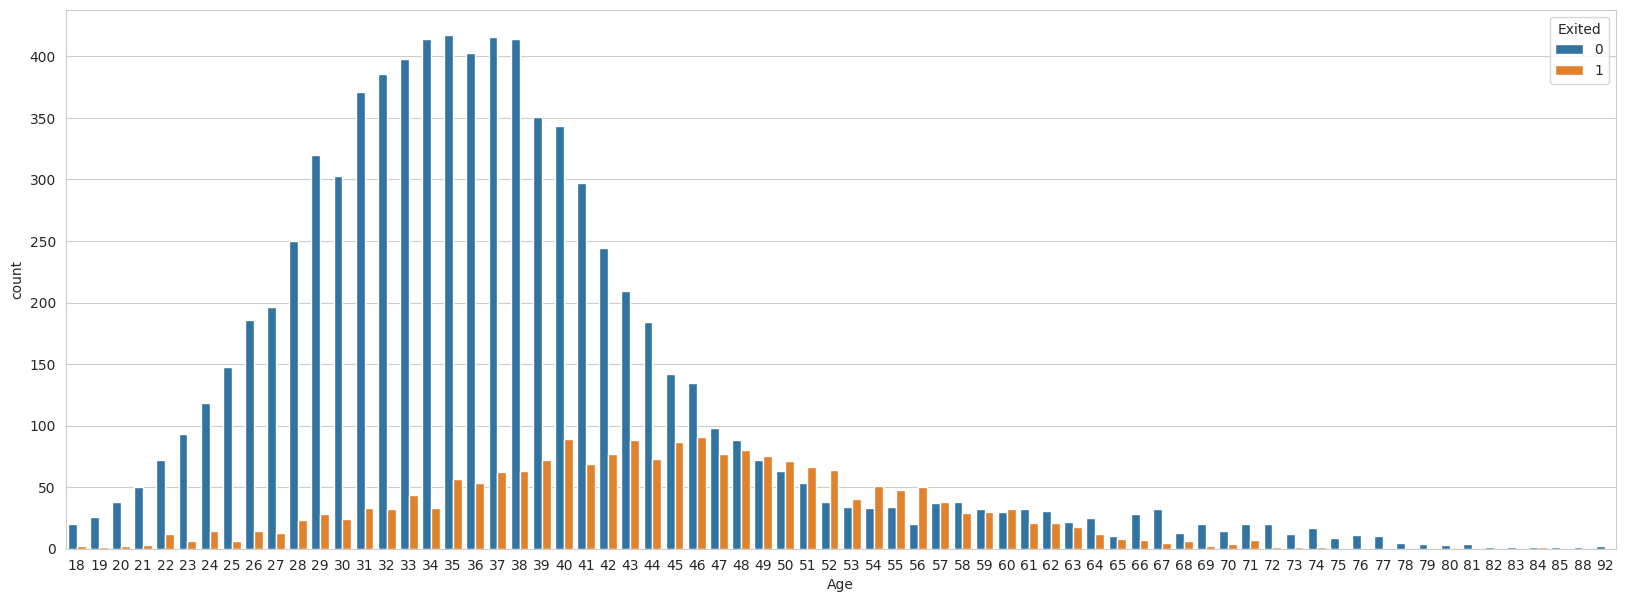

In [19]:
plt.figure(figsize=(20, 7))
sns.countplot(x='Age', hue='Exited', data=df)
plt.show()

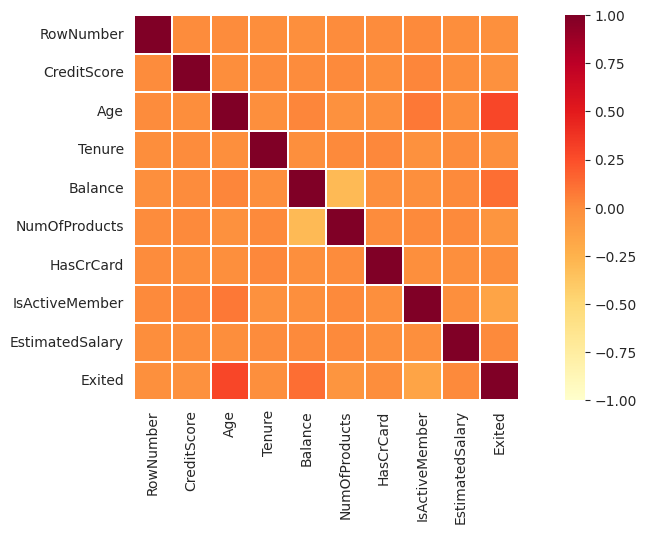

In [20]:
plt.figure(figsize=(12, 5))
sns.heatmap(df.corr(numeric_only=True),
            vmin=-1,
            vmax= 1,
            cmap= 'YlOrRd',
            linewidths=.12,
            linecolor='white',
            fmt='.2g',
            square=True);

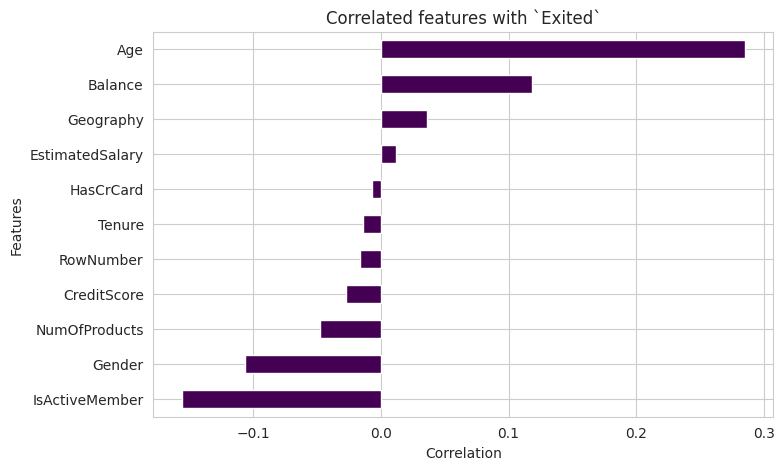

In [21]:

# Encode categorical variables to numeric values
label_encoder = LabelEncoder()
df['Geography'] = label_encoder.fit_transform(df['Geography'])
df['Gender'] = label_encoder.fit_transform(df['Gender'])

# Calculate correlations with 'Exited' after converting categorical variables to numeric
correlation_data = df.corr()['Exited'][:-1].sort_values()

plt.figure(figsize=(8, 5))
correlation_data.plot(kind='barh', colormap='viridis')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Correlated features with `Exited`')
plt.show()


In [22]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,850,2,0,43,2,125510.82,1,1,1,79084.10,0


## Preprocessing of Data

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [24]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.1,
                                                    random_state=seed)


In [25]:
scaler = MinMaxScaler()


In [26]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling & Model Performance

### without class_weigth

In [27]:
X_train.shape

(9000, 11)

In [28]:
from tensorflow.keras.optimizers import Adam
model = Sequential()

tf.random.set_seed(seed)

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=["Recall"])

In [29]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=15)
#The patience is often set somewhere between 10 and 100 (10 or 20 is more common),
#but it really depends on your dataset and network.

In [30]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop])

Epoch 1/200
64/64 [==============================] - 2s 9ms/step - loss: 0.5295 - recall: 0.0030 - val_loss: 0.4912 - val_recall: 0.0000e+00
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 0.4937 - recall: 0.0000e+00 - val_loss: 0.4773 - val_recall: 0.0000e+00
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4841 - recall: 0.0024 - val_loss: 0.4705 - val_recall: 0.0000e+00
Epoch 4/200
64/64 [==============================] - 0s 4ms/step - loss: 0.4769 - recall: 0.0079 - val_loss: 0.4643 - val_recall: 0.0055
Epoch 5/200
64/64 [==============================] - 0s 4ms/step - loss: 0.4711 - recall: 0.0212 - val_loss: 0.4576 - val_recall: 0.0221
Epoch 6/200
64/64 [==============================] - 0s 5ms/step - loss: 0.4651 - recall: 0.0278 - val_loss: 0.4519 - val_recall: 0.0166
Epoch 7/200
64/64 [==============================] - 0s 4ms/step - loss: 0.4605 - recall: 0.0448 - val_loss: 0.4457 - val_recall: 0.0773
Epoch 8/200
64/64 [======

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                192       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337 (1.32 KB)
Trainable params: 337 (1.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
loss_df = pd.DataFrame(model.history.history)
loss_df.head()

,loss,recall,val_loss,val_recall
0,0.529529,0.003027,0.491222,0.000000
1,0.493686,0.000000,0.477250,0.000000
2,0.484057,0.002421,0.470536,0.000000
3,0.476941,0.007869,0.464296,0.005525
4,0.471091,0.021186,0.457620,0.022099


<Axes: >

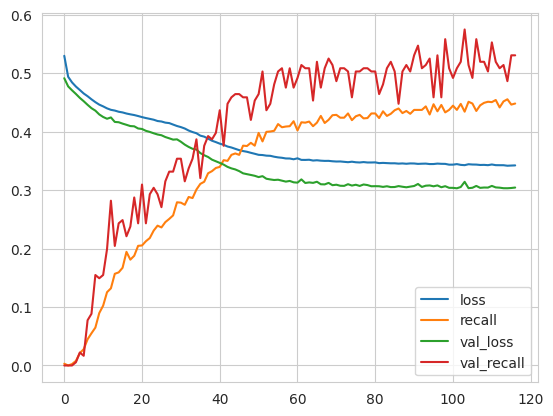

In [33]:
loss_df.plot()

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

32/32 [==============================] - 0s 1ms/step
[[758  38]
 [104 100]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       796
           1       0.72      0.49      0.58       204

    accuracy                           0.86      1000
   macro avg       0.80      0.72      0.75      1000
weighted avg       0.85      0.86      0.85      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

32/32 [==============================] - 0s 1ms/step


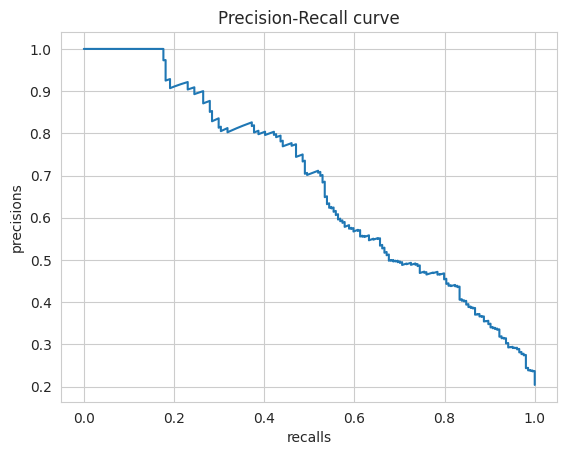

In [35]:
from sklearn.metrics import precision_recall_curve
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()
# roc curve, sınıflandırma performansını gösterir

In [36]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_pred_proba)

0.6805373811348869

### with class_weigth

In [37]:
model = Sequential()

tf.random.set_seed(seed)

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=["Recall"])

In [38]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [39]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop],
          class_weight=class_weights)

Epoch 1/200
64/64 [==============================] - 1s 8ms/step - loss: 0.6944 - recall: 0.8432 - val_loss: 0.7051 - val_recall: 0.7956
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 0.6781 - recall: 0.7149 - val_loss: 0.6819 - val_recall: 0.7072
Epoch 3/200
64/64 [==============================] - 0s 4ms/step - loss: 0.6627 - recall: 0.6889 - val_loss: 0.6534 - val_recall: 0.6243
Epoch 4/200
64/64 [==============================] - 0s 4ms/step - loss: 0.6468 - recall: 0.6792 - val_loss: 0.6236 - val_recall: 0.6133
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6334 - recall: 0.6646 - val_loss: 0.6340 - val_recall: 0.6961
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6193 - recall: 0.6731 - val_loss: 0.5784 - val_recall: 0.6243
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6095 - recall: 0.6719 - val_loss: 0.6074 - val_recall: 0.7127
Epoch 8/200
64/64 [======================

<Axes: >

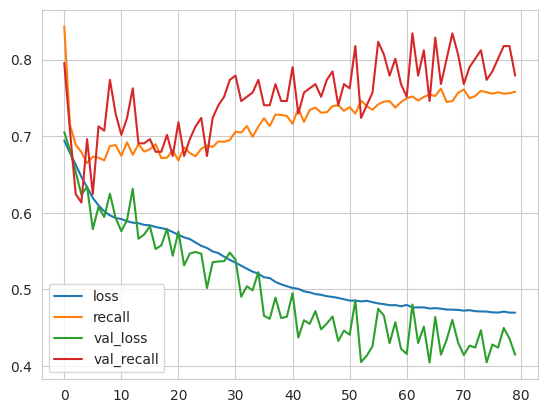

In [40]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [41]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

32/32 [==============================] - 0s 2ms/step
[[635 161]
 [ 50 154]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       796
           1       0.49      0.75      0.59       204

    accuracy                           0.79      1000
   macro avg       0.71      0.78      0.73      1000
weighted avg       0.84      0.79      0.80      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

32/32 [==============================] - 0s 1ms/step


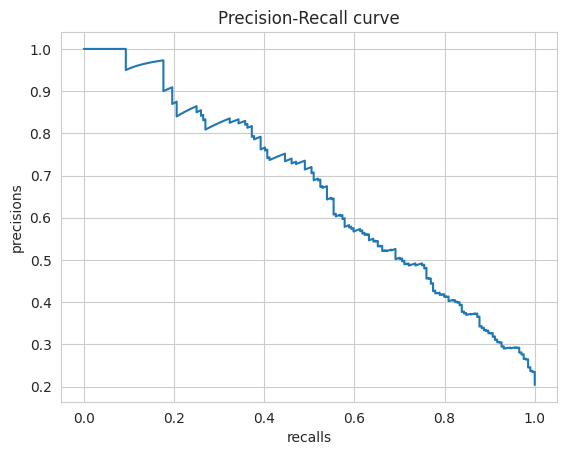

In [42]:
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()
# roc curve, sınıflandırma performansını gösterir

In [43]:
average_precision_score(y_test, y_pred_proba)   #0.692983743350624

0.665629053225956

In [44]:
from tensorflow.keras.optimizers import Adadelta, RMSprop, Nadam, Adam, SGD
def build_classifier(optimizer,learn_rate):
    classifier = Sequential()
    classifier.add(Dense(units=16, activation='relu'))
    classifier.add(Dense(units=8, activation='relu'))
    classifier.add(Dense(units=1, activation='sigmoid'))
    classifier.compile(optimizer=optimizer(learn_rate),
                       loss='binary_crossentropy',
                       metrics=['Recall'])
    return classifier

In [45]:
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [46]:
from sklearn.model_selection import GridSearchCV

tf.random.set_seed(seed)

classifier = KerasClassifier(build_fn=build_classifier, epochs=200)
parameters = {
    'batch_size': [128, 256],
    'optimizer': [Adam, RMSprop, Nadam, Adadelta, SGD],
    'learn_rate': [0.001, 0.003, 0.005]
}
grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='recall',
                          cv=5,
                          n_jobs=-1,
                          verbose=0)
#grid_model.fit(X_train,y_train, class_weight=class_weights)

In [47]:
# Create a custom wrapper class
class CustomKerasClassifier(KerasClassifier):
    def __init__(self, build_fn=None, learn_rate=0.001, **kwargs):
        self.learn_rate = learn_rate
        super(CustomKerasClassifier, self).__init__(build_fn=build_fn, **kwargs)

    def build_fn(self):
        return build_classifier(learn_rate=self.learn_rate)

# Create a CustomKerasClassifier instance
classifier = CustomKerasClassifier(epochs=200, batch_size=128)

# Define the parameters grid for grid search
parameters = {
    'learn_rate': [0.001, 0.003, 0.005],
    'batch_size': [128, 256]
}

In [48]:
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [49]:


classifier = KerasClassifier(build_fn=build_classifier, epochs=200)
parameters = {
    'batch_size': [128, 256],
    'optimizer': [Adam, RMSprop, Nadam, Adadelta, SGD],
    'learn_rate': [0.001, 0.003, 0.005]
}
grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='recall',
                          cv=5,
                          n_jobs=-1,
                          verbose=0)

In [50]:
#grid_model.fit(X_train, y_train, class_weight=class_weights)

### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for grid_model

In [51]:
#y_pred_proba = grid_model.predict(X_test)
#precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
#plt.plot(recalls, precisions, label='ANN')
#plt.xlabel('recalls')
#plt.ylabel('precisions')
#plt.title('Precision-Recall curve')
#plt.show()

In [52]:
average_precision_score(y_test, y_pred_proba)

0.665629053225956

## Final Model and Model Deployment

In [53]:
import pickle

pickle.dump(scaler, open("scaler_churn", 'wb'))

In [54]:
tf.random.set_seed(seed)

model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate=0.003)

model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=["Recall"])

model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          callbacks=[early_stop],
          batch_size=256,
          epochs=200,
          verbose=1,
          class_weight=class_weights)
# {'batch_size': 256,'learn_rate': 0.003,'optimizer': keras.optimizer_v2.adam.Adam}
# pay attention!! validation data

Epoch 1/200
36/36 [==============================] - 1s 10ms/step - loss: 0.6880 - recall: 0.3306 - val_loss: 0.6782 - val_recall: 0.5441
Epoch 2/200
36/36 [==============================] - 0s 4ms/step - loss: 0.6581 - recall: 0.6378 - val_loss: 0.6599 - val_recall: 0.7059
Epoch 3/200
36/36 [==============================] - 0s 4ms/step - loss: 0.6270 - recall: 0.6819 - val_loss: 0.6420 - val_recall: 0.7402
Epoch 4/200
36/36 [==============================] - 0s 3ms/step - loss: 0.6071 - recall: 0.6874 - val_loss: 0.6437 - val_recall: 0.7500
Epoch 5/200
36/36 [==============================] - 0s 4ms/step - loss: 0.5929 - recall: 0.6945 - val_loss: 0.5817 - val_recall: 0.6667
Epoch 6/200
36/36 [==============================] - 0s 4ms/step - loss: 0.5846 - recall: 0.6781 - val_loss: 0.6481 - val_recall: 0.7598
Epoch 7/200
36/36 [==============================] - 0s 4ms/step - loss: 0.5805 - recall: 0.6830 - val_loss: 0.5679 - val_recall: 0.6667
Epoch 8/200
36/36 [=====================

<Axes: >

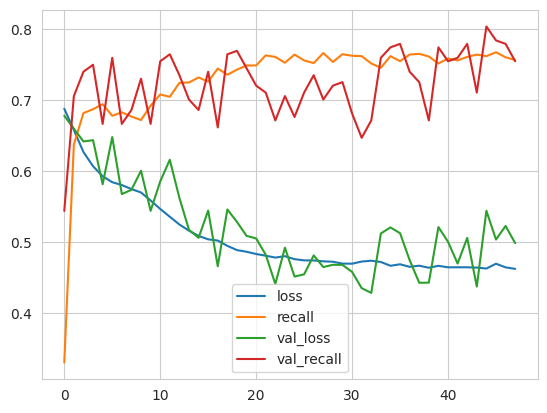

In [55]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [56]:
loss, recall = model.evaluate(X_test, y_test, verbose=0)
print("loss : ", loss)
print("recall : ", recall)

loss :  0.49871906638145447
recall :  0.7549019455909729


In [57]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

32/32 [==============================] - 0s 1ms/step
[[596 200]
 [ 50 154]]
              precision    recall  f1-score   support

           0       0.92      0.75      0.83       796
           1       0.44      0.75      0.55       204

    accuracy                           0.75      1000
   macro avg       0.68      0.75      0.69      1000
weighted avg       0.82      0.75      0.77      1000



In [58]:
model.save('model_churn.h5')

### Prediction

In [59]:
single_customer = df.drop('Exited', axis=1).iloc[0]
single_customer

RowNumber               1.00
CreditScore           619.00
Geography               0.00
Gender                  0.00
Age                    42.00
Tenure                  2.00
Balance                 0.00
NumOfProducts           1.00
HasCrCard               1.00
IsActiveMember          1.00
EstimatedSalary    101348.88
Name: 0, dtype: float64

In [60]:
single_customer = scaler.transform(single_customer.values.reshape(-1, 11))
single_customer

array([[0.        , 0.538     , 0.        , 0.        , 0.32432432,
        0.2       , 0.        , 0.        , 1.        , 1.        ,
        0.50673489]])

In [61]:
y_pred =(model.predict(single_customer) > 0.5).astype("int32")
y_pred

1/1 [==============================] - 0s 22ms/step


array([[1]], dtype=int32)

In [62]:
df["Exited"].iloc[0]

1

## Comparison with ML

### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
log_model=LogisticRegression(class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[548 248]
 [ 57 147]]
              precision    recall  f1-score   support

           0       0.91      0.69      0.78       796
           1       0.37      0.72      0.49       204

    accuracy                           0.69      1000
   macro avg       0.64      0.70      0.64      1000
weighted avg       0.80      0.69      0.72      1000



### Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier


In [66]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[770  26]
 [122  82]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       796
           1       0.76      0.40      0.53       204

    accuracy                           0.85      1000
   macro avg       0.81      0.68      0.72      1000
weighted avg       0.84      0.85      0.83      1000



___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___